In [1]:
import os
import json
import torch
import torch_geometric

from rdkit import Chem
import matplotlib.pyplot as plt

/home/danqingwang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-21 02:40:52.850904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
from util import MolFromGraphs, valid_checking
from data import load_dataset

from tqdm import tqdm
from rdkit import Chem, RDLogger

from gnn import load_trained_prediction

In [4]:
dataset_name = 'aids'
dataset = load_dataset(dataset_name)


In [89]:
dataset_name = 'aids'
summary_name = 'results/aids/runs/counterfactuals.pt'
# summary_name = 'results/aids/runs/factuals.pt'

def get_cand_and_cover(summary_name, dataset_name):
    summary = torch.load(summary_name)

    graphs = load_dataset(dataset_name)
    
    mapping_info = json.load(open('data/{}/raw/mapping_info.json'.format(dataset_name)))
    node_mapping = mapping_info['keep_node_mapping']

    preds = load_trained_prediction(dataset_name, device='cpu')
    preds = preds.cpu().numpy()
    input_graph_indices = np.array(range(len(preds)))[preds == 0]
    input_graphs = graphs[input_graph_indices.tolist()]

    valid_cand_mol = []
    for cand in summary['counterfactual_candidates']:
        graph_hasp = cand['graph_hash']
        graph = summary['graph_map'][graph_hasp]
        if valid_checking(graph, node_mapping):
            mol = MolFromGraphs(graph, node_mapping)
            covers = [input_graphs[idx] for idx in cand['input_graphs_covering_list'].coalesce().indices()[0]]
            ins = {
                'cand': mol,
                'cover': covers
            }
            valid_cand_mol.append(ins)

    return valid_cand_mol, node_mapping


In [90]:
valid_cand_mol, node_mapping = get_cand_and_cover(summary_name, dataset_name)

[03:19:45] Explicit valence for atom # 9 F, 2, is greater than permitted
[03:19:45] Explicit valence for atom # 4 N, 4, is greater than permitted
[03:19:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[03:19:45] Explicit valence for atom # 9 N, 5, is greater than permitted
[03:19:45] Explicit valence for atom # 10 O, 3, is greater than permitted
[03:19:45] Explicit valence for atom # 3 O, 3, is greater than permitted
[03:19:45] Explicit valence for atom # 4 F, 2, is greater than permitted
[03:19:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[03:19:45] Explicit valence for atom # 7 Br, 2, is greater than permitted
[03:19:45] Explicit valence for atom # 9 Cl, 4, is greater than permitted
[03:19:45] Explicit valence for atom # 4 C, 5, is greater than permitted
[03:19:45] Explicit valence for atom # 10 Cl, 5, is greater than permitted
[03:19:45] Explicit valence for atom # 10 Na, 2, is greater than permitted
[03:19:45] Explicit valence for atom # 2 C, 

In [5]:
def show_mol(mol, ax=None):
    im = Chem.Draw.MolToImage(mol)
    if ax is None:
        plt.axis("off")
        plt.imshow(im)
    else:
        ax.axis("off")
        ax.imshow(im)

## High resolution molecule

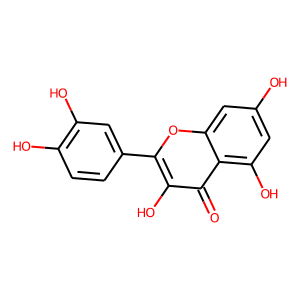

In [19]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

smiles = 'C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O' 
m = Chem.MolFromSmiles(smiles)

def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

SVG(moltosvg(m))

In [23]:
class HorizontalDisplay:
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 0px;">{0}</div>'
        return "\n".join(template.format(arg)
                         for arg in self.args)

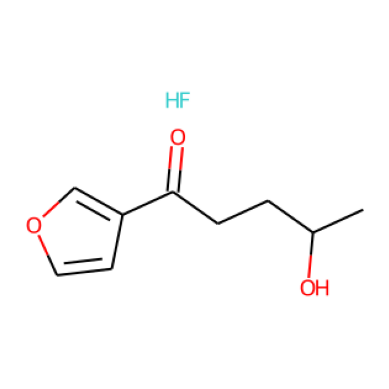

In [8]:
show_mol(valid_cand_mol[1]['cand'])

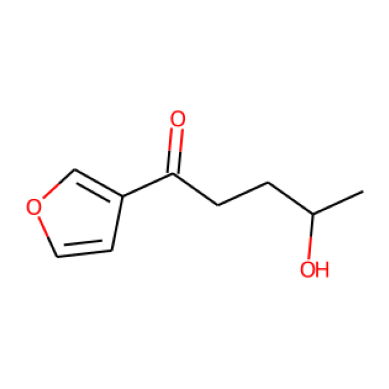

In [9]:
show_mol(MolFromGraphs(valid_cand_mol[1]['cover'][0], node_mapping))

In [10]:
def print_cand(valid_cand_mol, cand_idx, save=False):
    cover_num = len(valid_cand_mol[cand_idx]['cover'])
    print(cover_num)

    nrow, ncol = 2, max(cover_num, 2)
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol)

    for i in range(nrow):
        for j in range(ncol):
            ax[i][j].axis("off")
            if i == 0:
                if j == 0:
                    show_mol(valid_cand_mol[cand_idx]['cand'], ax=ax[i][j])
                else:
                    continue
            else:
                idx = j
                if idx >= cover_num:
                    break
                else:
                    cover_mol = MolFromGraphs(valid_cand_mol[cand_idx]['cover'][idx], node_mapping)
                    show_mol(cover_mol, ax=ax[i][j])
    if save:
        save_name = f'f_{cand_idx}.jpg'
        fig.savefig(save_name, dpi=200)

In [55]:
def print_covered_svg(valid_cand_mol, cand_idx, save=False):
    cover_num = len(valid_cand_mol[cand_idx]['cover'])
    print(cover_num)

    covered = [MolFromGraphs(valid_cand_mol[cand_idx]['cover'][x], node_mapping) for x in range(cover_num)]
    return HorizontalDisplay(*[moltosvg(x) for x in covered])

In [102]:
for idx in range(len(valid_cand_mol)):
    if len(valid_cand_mol[idx]['cover']) >= 2:
        print(idx)

1
4
27
39
41
50
51
53
55
67
69
71
79
80
82
83
85
86
91
96
98
108
110
116
118
120
125
137
142
145
146
158
159
161
181
184
186
190
209
215
216
229
267
283
298
301
302
304
305
320
323
345
351
352
354
361
373
379
388
389
403
404
414
422
423
425
432
433
437
439
468
469
470
472
474
496
525
528
532
533
548
589
590
618
619
620
639
666
675
712
717
718
728
730
731
734
748
757
758
759
763
764
765
791
804
805
817
820
821
838
839
869
872
897
899
901
921
922
923
924
953
955
957
960
964
972
983
988
990
994
996
998
1004
1027
1032
1033
1087
1104
1105
1109
1116
1118
1129
1130
1134
1135
1136
1138
1139
1143
1154
1173
1178
1179
1196
1197
1198
1215
1216
1217
1229
1241
1250
1254
1258
1264
1268
1295
1300
1301
1302
1309
1333
1346
1351
1367
1386
1388
1390
1393
1420
1441
1446
1447
1454
1455
1457
1462
1463
1478
1480
1517
1532
1551
1572
1575
1600
1604
1613
1617
1618
1619
1620
1623
1629
1658
1668
1684
1685
1686
1687
1690
1692
1701
1706
1755
1756
1759
1763
1782
1837
1844
1845
1846
1849
1868
1882
1885
1887
1903
1905


In [110]:
print_covered_svg(valid_cand_mol, 27)

2


In [104]:
HorizontalDisplay(moltosvg(valid_cand_mol[27]['cand']))

In [75]:
print(HorizontalDisplay(moltosvg(valid_cand_mol[28]['cand']))._repr_html_())

<div style="float: left; padding: 0px;"><?xml version='1.0' encoding='iso-8859-1'?>
<svg version='1.1' baseProfile='full'
              xmlns='http://www.w3.org/2000/svg'
                      xmlns:rdkit='http://www.rdkit.org/xml'
                      xmlns:xlink='http://www.w3.org/1999/xlink'
                  xml:space='preserve'
width='300px' height='300px' viewBox='0 0 300 300'>
<!-- END OF HEADER -->
<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='300.0' height='300.0' x='0.0' y='0.0'> </rect>
<path class='bond-0 atom-0 atom-1' d='M 189.6,230.3 L 173.1,213.7' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-1 atom-0 atom-5' d='M 189.6,230.3 L 212.3,224.3' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-1 atom-0 atom-5' d='M 191.8,224.9 L 207.7,220.7' style='fill:none;fi

In [73]:
print(xx._repr_html_())

<div style="float: left; padding: 0px;"><?xml version='1.0' encoding='iso-8859-1'?>
<svg version='1.1' baseProfile='full'
              xmlns='http://www.w3.org/2000/svg'
                      xmlns:rdkit='http://www.rdkit.org/xml'
                      xmlns:xlink='http://www.w3.org/1999/xlink'
                  xml:space='preserve'
width='300px' height='300px' viewBox='0 0 300 300'>
<!-- END OF HEADER -->
<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='300.0' height='300.0' x='0.0' y='0.0'> </rect>
<path class='bond-0 atom-0 atom-1' d='M 125.2,185.9 L 113.6,165.9' style='fill:none;fill-rule:evenodd;stroke:#0000FF;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-0 atom-0 atom-1' d='M 113.6,165.9 L 102.1,145.9' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-1 atom-0 atom-5' d='M 139.1,196.0 L 164.0,196.0' style='fill:none;fi

2


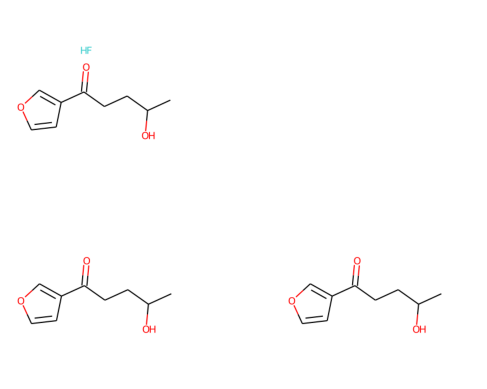

In [12]:
print_cand(valid_cand_mol, 1)

1


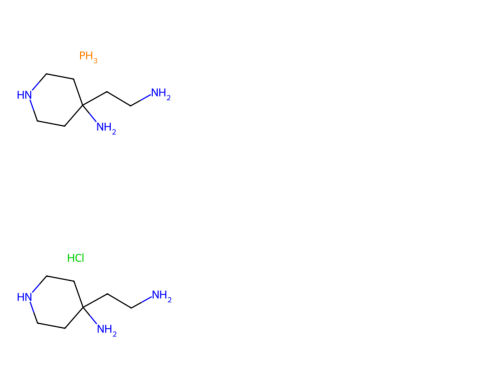

In [12]:
print_cand(2)

1


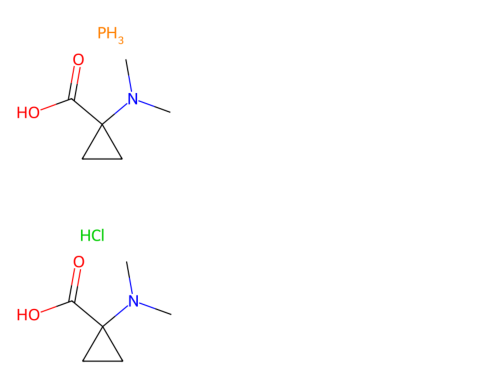

In [13]:
print_cand(3)

2


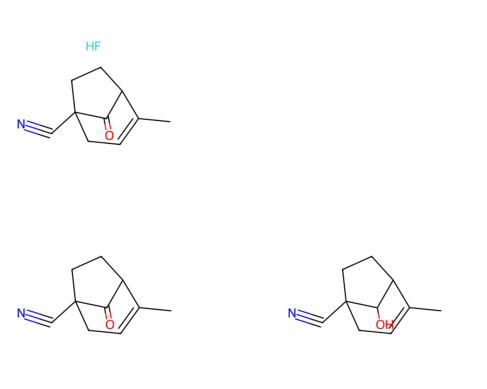

In [14]:
print_cand(4)

1


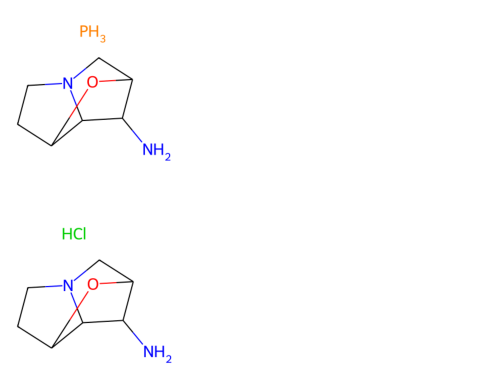

In [15]:
print_cand(5)

1


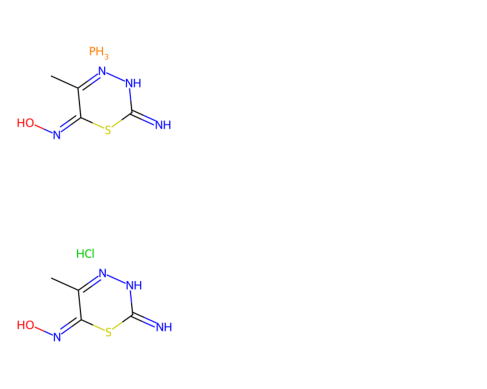

In [16]:
print_cand(6)

# New result


In [8]:
dataset_name = 'aids'
summary_name = 'results/test5w/aids/runs/counterfactuals.pt'

valid_cand_mol, node_mapping = get_cand_and_cover(summary_name, dataset_name)

[17:48:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
[17:48:09] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
[17:48:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:48:10] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10
[17:48:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:48:10] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:48:10

1


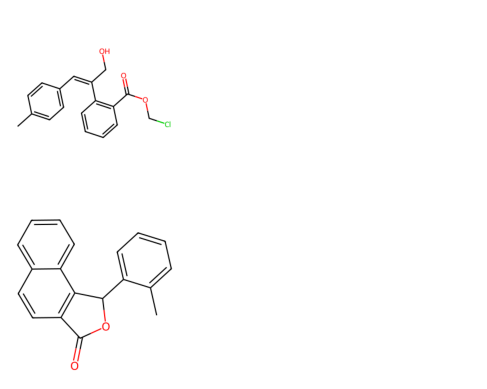

In [29]:
print_cand(valid_cand_mol,5, save=True)